In [4]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import util
from test_to_bw_fast import read_model
import metrics
import wandb
from test_to_bw_fast import get_config
# from tfr_evaluate import get_true_pred, evaluate_per_cell_line
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from test_to_bw_fast import open_bw
import numpy as np
# from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from tqdm import tqdm
from scipy.spatial import distance
from scipy import stats
import pickle, os
import tfr_evaluate 

# from metrics import np_poiss, np_mse, get_scaled_mse, get_js_dist, np_pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
all_run_metadata = []
for run_path in glob.glob('paper_runs/bpnet/augmentation_48/*'):
    all_run_metadata.append(tfr_evaluate.get_run_metadata(run_path))
all_run_metadata = pd.concat(all_run_metadata)
all_run_metadata['dataset'] = ['random_chop' if 'random' in data_dir else 'peak_centered' for data_dir in all_run_metadata['data_dir'].values]
model_paths = []
for i, df in (all_run_metadata[all_run_metadata['bin_size']==128]).groupby(['crop', 'rev_comp', 'dataset']):
    assert df.shape[0] == 3, 'mip'
    model_paths.append(df.iloc[0]['run_dir'])

In [6]:
model_paths

['paper_runs/bpnet/augmentation_48/run-20211007_023315-r98fu6p6',
 'paper_runs/bpnet/augmentation_48/run-20211005_000325-r241ppq0',
 'paper_runs/bpnet/augmentation_48/run-20211006_203118-13gp6tki',
 'paper_runs/bpnet/augmentation_48/run-20211005_161132-cmj8is1n',
 'paper_runs/bpnet/augmentation_48/run-20211006_075545-ytp3nsnj',
 'paper_runs/bpnet/augmentation_48/run-20211004_175719-9du76u2h',
 'paper_runs/bpnet/augmentation_48/run-20211004_063549-ef37qlz9',
 'paper_runs/bpnet/augmentation_48/run-20211005_062707-s08a63co']

In [65]:
best_run_const = augm_results[augm_results['run_dir'] == '/home/shush/profile/QuantPred/paper_runs/basenji/augmentation_basenji/run-20210925_100240-hhq8kgqi']



In [66]:
best_run_const = best_run_const[(best_run_const['eval type']=='whole')&(best_run_const['pred type']=='raw')]

In [67]:
# load robust pred results
best_run_shifted = pd.read_csv('robustness_test_results/run-20210925_100240-hhq8kgqi/performance.csv')

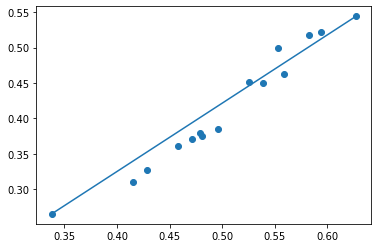

In [68]:
plt.scatter(best_run_shifted['pr_corr'].values, best_run_const['pr_corr'].values)
x_coords = [np_func(best_run_shifted['pr_corr'].values) for np_func in [np.min, np.max]]
y_coords = [np_func(best_run_const['pr_corr'].values) for np_func in [np.min, np.max]]
plt.plot(x_coords, y_coords)

In [64]:
for run_dir in glob.glob('paper_runs/basenji/augmentation_basenji/*'):
    config = get_config(run_dir)
    if (config['crop']['value'] == False) & (('peak_centered' in config['data_dir']['value'])) &(config['rev_comp']['value']==False) & (config['bin_size']['value']==128):
        print(run_dir)

paper_runs/basenji/augmentation_basenji/run-20210925_100240-hhq8kgqi
paper_runs/basenji/augmentation_basenji/run-20210924_103016-g7jm99d0
paper_runs/basenji/augmentation_basenji/run-20210924_045502-yoc02hk8


In [35]:
for run_dir in glob.glob('paper_runs/bpnet/augmentation_48/*'):
    config = get_config(run_dir)

    if (config['crop']['value'] == False) & (('random_chop/i_2048_w_1' in config['data_dir']['value'])) &(config['rev_comp']['value']==True) & (config['bin_size']['value']==1):
        print(run_dir)

paper_runs/bpnet/augmentation_48/run-20211006_190817-456uzbu4
paper_runs/bpnet/augmentation_48/run-20211005_140453-8r3vxwo2
paper_runs/bpnet/augmentation_48/run-20211003_192542-buvtqrhv


In [36]:
get_config('paper_runs/bpnet/augmentation_48/run-20211006_190817-456uzbu4')


{'wandb_version': 1,
 '_wandb': {'desc': None,
  'value': {'cli_version': '0.10.33',
   'framework': 'tensorflow',
   'is_jupyter_run': False,
   'is_kaggle_kernel': False,
   'python_version': '3.6.9',
   't': {1: [3, 5], 2: [3, 5], 3: [2], 4: '3.6.9', 5: '0.10.33', 8: [5]}}},
 'bin_size': {'desc': None, 'value': 1},
 'crop': {'desc': None, 'value': False},
 'data_dir': {'desc': None,
  'value': 'datasets/complete/random_chop/i_2048_w_1'},
 'l_rate': {'desc': None, 'value': 0.001},
 'loss_fn': {'desc': None, 'value': 'poisson'},
 'model_fn': {'desc': None, 'value': 'bpnet'},
 'num_epochs': {'desc': None, 'value': 100},
 'rev_comp': {'desc': None, 'value': True},
 'window_size': {'desc': None, 'value': 2048}}

In [84]:
def add_augmentation(df):
    crop_dict = {'False':'constant', 'r_crop':'shift'}
    df['input window'] = [crop_dict[c] for c in df['crop']]
    rev_dict = {False: 'No RC ', True: 'RC '}

    df['augmentation'] = [rev_dict[c] for c in df['rev_comp']] + df['input window']
    aug_dict = {'RC shift': 'RC + Shift', 'No RC shift': 'Shift', 
                'RC constant':'RC', 'No RC constant': 'None'}
    df['augmentation'] = [aug_dict[a] for a in df['augmentation']]
    return df

In [85]:
# augmentation_results = pd.read_csv('summary_metrics_tables/AUGMENTATION_1_128.csv') # basenji
augmentation_results = pd.read_csv('summary_metrics_tables/augmentation_48.csv') # bpnet
dataset_translation = {'random_chop': 'thresholded', 'peak_centered': 'peak centered'}
both_testset_types = []
for testset_type in ['whole', 'idr']:
    raw_whole_results = augmentation_results[(augmentation_results['pred type']=='raw')&
                         (augmentation_results['eval type']==testset_type)]

    raw_whole_results['dataset'] = [dataset_translation[r.split('complete/')[-1].split('/')[0]] for r in raw_whole_results['data_dir']]

    raw_whole_results = add_augmentation(raw_whole_results)

    run_ids = [[i for j in range(15)] for i in range(raw_whole_results.shape[0]//15)]
    flat_run_ids = [item for sublist in run_ids for item in sublist]
    raw_whole_results['run id'] = flat_run_ids
    metrics = raw_whole_results.groupby('run id').mean().reset_index().iloc[:,:7]
    descriptions = raw_whole_results.iloc[:,7:]
    avg_metrics_per_run = metrics.merge(descriptions,how='left', left_on='run id',right_on='run id').drop_duplicates(subset='run id')
    avg_metrics_per_run['Test set'] = testset_type
    both_testset_types.append(avg_metrics_per_run)

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [86]:
both_testset_types = pd.concat(both_testset_types)

In [87]:
both_testset_types[(both_testset_types['augmentation']=='None') &
                  (both_testset_types['augmentation']=='None')]

,run id,index,mse,js_per_seq,js_conc,poiss,pr,pred type,eval type,bin_size,...,l_rate,loss_fn,model_fn,num_epochs,rev_comp,window_size,dataset,input window,augmentation,Test set
60,4,7,0.841906,0.293588,0.356902,0.841978,0.505938,raw,whole,128,...,0.001,poisson,bpnet,100,False,2048,peak centered,constant,None,whole
120,8,7,0.878199,0.339834,0.379999,0.835749,0.525689,raw,whole,1,...,0.001,poisson,bpnet,100,False,2048,peak centered,constant,None,whole
135,9,7,0.681719,0.330491,0.359322,0.802989,0.588704,raw,whole,1,...,0.001,poisson,bpnet,100,False,2048,thresholded,constant,None,whole
180,12,7,0.883524,0.340412,0.380128,0.836590,0.525900,raw,whole,1,...,0.001,poisson,bpnet,100,False,2048,peak centered,constant,None,whole
210,14,7,0.849195,0.293869,0.357905,0.843123,0.500115,raw,whole,128,...,0.001,poisson,bpnet,100,False,2048,peak centered,constant,None,whole
285,19,7,0.681107,0.330255,0.359276,0.803044,0.589389,raw,whole,1,...,0.001,poisson,bpnet,100,False,2048,thresholded,constant,None,whole
300,20,7,0.659135,0.283390,0.335416,0.811544,0.565444,raw,whole,128,...,0.001,poisson,bpnet,100,False,2048,thresholded,constant,None,whole
330,22,7,0.885403,0.340147,0.379395,0.836607,0.526616,raw,whole,1,...,0.001,poisson,bpnet,100,False,2048,peak centered,constant,None,whole
465,31,7,0.852206,0.293643,0.357879,0.843216,0.500687,raw,whole,128,...,0.001,poisson,bpnet,100,False,2048,peak centered,constant,None,whole
480,32,7,0.652575,0.283682,0.335787,0.811846,0.565022,raw,whole,128,...,0.001,poisson,bpnet,100,False,2048,thresholded,constant,None,whole


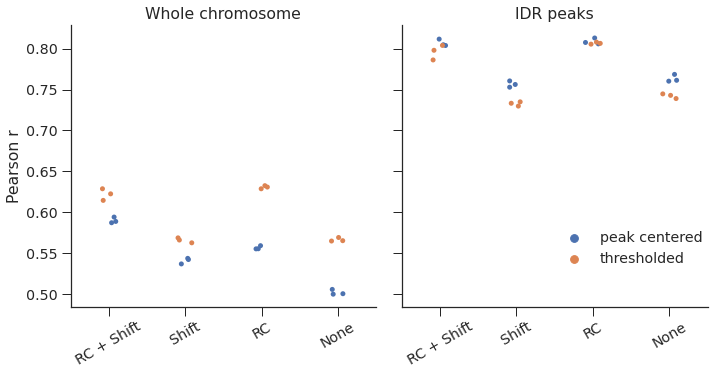

In [88]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
binsize=128
df = both_testset_types[both_testset_types['bin_size']==binsize].sort_values('dataset')
# sns.swarmplot(data=df, 
#                x='augmentation', y='pr', hue='dataset', order=['None', 'RC', 'Shift', 'RC + Shift'])
# plt.title('basenji, bin size={}'.format(binsize));


g =sns.catplot(data=df, x='augmentation', y='pr', hue='dataset',# marker='smooth',
                col='Test set', order=['RC + Shift', 'Shift', 'RC', 'None'])
g.set_xticklabels(rotation=30)
# g.axes[0][0].set_xticks(g.axes[0][1].get_xticks())
g.set_xlabels('')
[t.set_visible(True) for t in [g.axes[0][0].get_xticklabels()][0]]
g.set_ylabels('Pearson r')
g.axes[0][0].set_title('Whole chromosome')
g.axes[0][1].set_title('IDR peaks')


g.axes[0][1].legend(loc='lower center',bbox_to_anchor=(0.75,0.1),frameon=False)
g._legend.remove()


In [13]:
def filter_augm_df(filepath_path, avg_cells=True, remove_ccrop=True, i=3):
    # filepath_path = whole_path
    raw_df = pd.read_csv(filepath_path)
    if remove_ccrop:
        raw_df = raw_df[raw_df['crop'] != 'c_crop']
    if avg_cells:
        mean_vals = raw_df.groupby('run_path')['mse', 'JS', 'poisson NLL', 'pearson r'].mean()
        df = mean_vals.merge(raw_df.iloc[:,6:].drop_duplicates(), on='run_path')
    else:
        df = raw_df
    lower_case_dtype = [' '.join(d.split('/')[i].split('_')) for d in df['data_dir']]
    upper_case_dtype = [i.capitalize() for i in lower_case_dtype]
    df['Dataset type'] = upper_case_dtype

    crop_dict = {'False':'constant', 'r_crop':'shift'}
    df['input window'] = [crop_dict[c] for c in df['crop']]
    rev_dict = {False: 'No RC ', True: 'RC '}

    df['augmentation'] = [rev_dict[c] for c in df['rev_comp']] + df['input window']
    aug_dict = {'RC shift': 'RC + Shift', 'No RC shift': 'Shift', 
                'RC constant':'RC', 'No RC constant': 'None'}
    df['augmentation'] = [aug_dict[a] for a in df['augmentation']]
    return df

In [3]:
def merge_and_avg(file_path):
    raw_df = pd.read_csv(file_path)
    mean_vals = raw_df.groupby('run_path')['mse', 'JS', 'poisson NLL', 'pearson r'].mean()
    df = mean_vals.merge(raw_df.iloc[:,6:].drop_duplicates(), on='run_path')
    return df

In [98]:
data_dir = '/home/shush/profile/QuantPred/datasets/chr8/complete/random_chop/i_2048_w_1/'
sts = util.load_stats(data_dir)
# testset = util.make_dataset(data_dir, 'test', sts, batch_size=512, shuffle=False)
targets = pd.read_csv(data_dir+'targets.txt', sep='\t')['identifier'].values
targets

array(['GM21381', 'GM23338', 'HepG2', 'RWPE2', 'HG03575', 'K562',
       'DND-41', 'GM12878', 'A549', 'HCT116', 'IMR-90', 'NCI-H929',
       'Panc1', 'PC-3', 'MCF'], dtype=object)

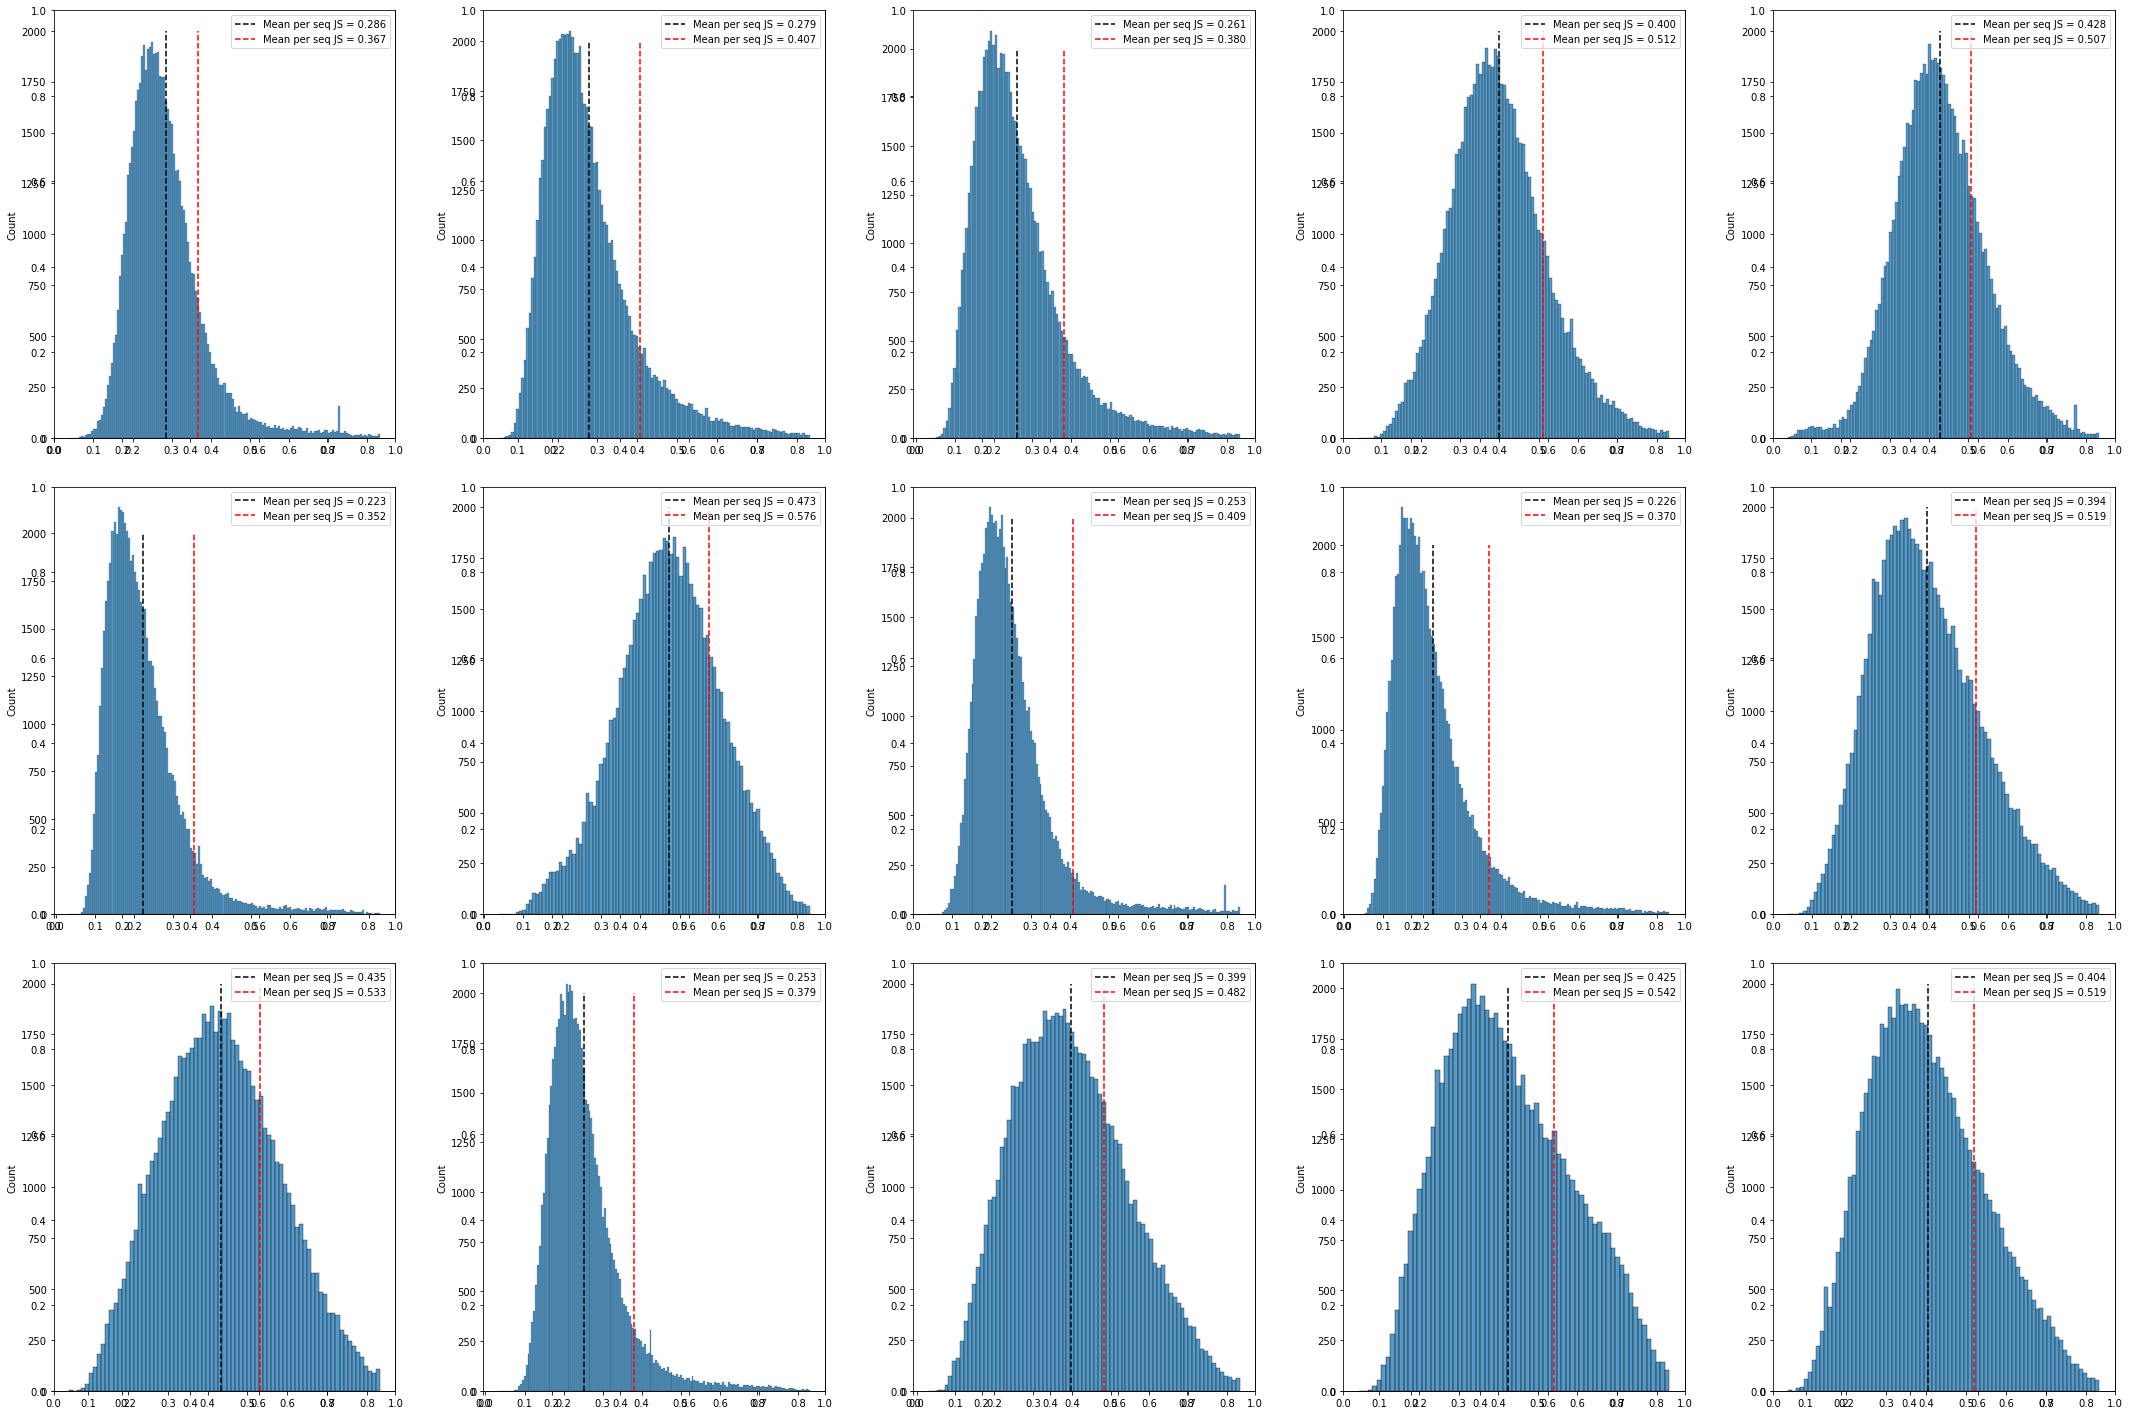

In [81]:
i = 0
nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=[30,20])
for i in range(nrows*ncols):
    ax = fig.add_subplot(nrows, ncols, i+1)
    sns.histplot(flat_js[:,i], ax=ax)
    mean_js = flat_js[:,i].mean()
    ax.vlines(mean_js, 0, 2000, color='k', linestyles='--', label='Mean per seq JS = {:0.3f}'.format(mean_js))
    ax.vlines(js[i], 0, 2000, color='r', linestyles='--', label='Mean per seq JS = {:0.3f}'.format(np.around(js[i], 3)))
    ax.legend()
plt.tight_layout()

# Augmentation for all bin sizes

In [71]:
summary_dir = 'summary_metrics_tables'
file_suffix = 'AUGMENTATION_BIN_SIZE.csv'
whole_path = os.path.join(summary_dir, 'WHOLE_'+file_suffix)
idr_path = os.path.join(summary_dir, 'IDR_'+file_suffix)
whole_df = filter_augm_df(whole_path, i=2)
idr_df = filter_augm_df(idr_path, i=2)
whole_df['Test set'] = 'whole chromosome'
idr_df['Test set'] = 'IDR peaks'

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


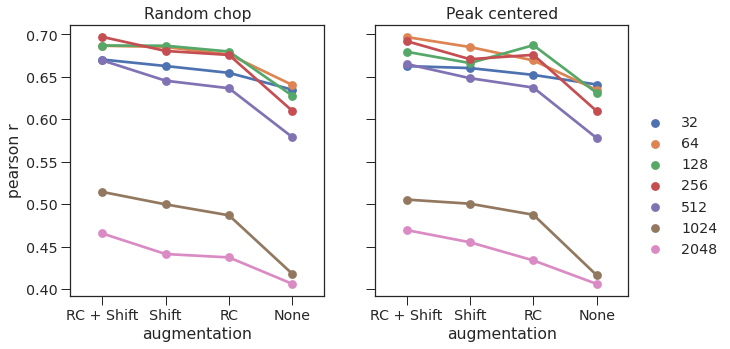

In [79]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
fig, axs = plt.subplots(1,2, sharey=True, figsize=[10, 5])
# rand_chop_df = idr_df[(idr_df['Dataset type']=='Random chop')&(idr_df['bin_size']<1000)]
# peak_cent_df = idr_df[(idr_df['Dataset type']=='Peak centered')&(idr_df['bin_size']<1000)]
rand_chop_df = idr_df[(idr_df['Dataset type']=='Random chop')]
peak_cent_df = idr_df[(idr_df['Dataset type']=='Peak centered')]
sns.pointplot(data=rand_chop_df, x='augmentation', y='pearson r',
                 order=['RC + Shift', 'Shift', 'RC', 'None'], hue='bin_size', ax=axs[0])
axs[0].set_title('Random chop')
sns.pointplot(data=peak_cent_df, x='augmentation', y='pearson r',
                 order=['RC + Shift', 'Shift', 'RC', 'None'], hue='bin_size', ax=axs[1])
axs[1].set_title('Peak centered')
# g.set_xticklabels(rotation=30)
# g.axes[0][0].set_xticks(g.axes[0][1].get_xticks())
# g.set_xlabels('')
# [t.set_visible(True) for t in [g.axes[0][0].get_xticklabels()][0]]
# g.set_ylabels('Pearson r')
# g.axes[0][0].set_title('Whole chromosome')
# g.axes[0][1].set_title('IDR peaks')


plt.legend(loc='lower center',bbox_to_anchor=(1.2,0.1),frameon=False)
axs[0].get_legend().remove()
axs[1].set_ylabel('');
# plt.xticks(g.axes[0][1].get_xticks())
# plt.title('Basenji augmentation')

In [82]:
whole_df['run_path'].values[0]

'/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_elzar_2/run-20210905_204925-27nmtpjk'

In [104]:
summary_dir = 'summary_metrics_tables'
file_suffix = 'BPNET_AUGMENTATION.csv'
whole_path = os.path.join(summary_dir, 'WHOLE_'+file_suffix)
idr_path = os.path.join(summary_dir, 'IDR_'+file_suffix)
whole_df = filter_augm_df(whole_path, True, i=3)
idr_df = filter_augm_df(idr_path, True, i=3)
whole_df['Test set'] = 'whole chromosome'
idr_df['Test set'] = 'IDR peaks'

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [105]:
# whole_df['targets'][np.argmax(whole_df['pearson r'])]

In [106]:
nosmooth_df

,run_path,mse,JS,poisson NLL,pearson r,data_dir,crop,rev_comp,smooth,Dataset type,input window,augmentation,Test set
2,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.678917,0.331213,0.699499,0.585235,./datasets/complete/peak_centered/i_2048_w_1/,False,False,False,Complete,constant,None,whole chromosome
3,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.668988,0.330930,0.699713,0.593086,./datasets/complete/random_chop/i_2048_w_1/,False,True,False,Complete,constant,RC,whole chromosome
8,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.693010,0.330351,0.700404,0.580561,./datasets/complete/random_chop/i_2048_w_1/,False,False,False,Complete,constant,None,whole chromosome
9,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.645237,0.329475,0.691608,0.611796,./datasets/complete/peak_centered/i_2048_w_1/,False,True,False,Complete,constant,RC,whole chromosome
14,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.698038,0.331528,0.705134,0.572351,./datasets/complete/random_chop/i_3072_w_1/,r_crop,False,False,Complete,shift,Shift,whole chromosome
15,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.669305,0.330871,0.698173,0.596902,./datasets/complete/peak_centered/i_3072_w_1/,r_crop,True,False,Complete,shift,RC + Shift,whole chromosome
17,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.673059,0.330515,0.698773,0.595196,./datasets/complete/random_chop/i_3072_w_1/,r_crop,True,False,Complete,shift,RC + Shift,whole chromosome
21,/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/ambe...,0.690285,0.331782,0.700005,0.583555,./datasets/complete/peak_centered/i_3072_w_1/,r_crop,False,False,Complete,shift,Shift,whole chromosome


In [107]:
nosmooth_df = whole_df[whole_df['smooth'] == 'False']
nosmooth_df[['augmentation', 'Dataset type', 'pearson r']].pivot(index='Dataset type', columns='augmentation', values='pearson r')

augmentation,None,RC,RC + Shift,Shift
Dataset type,,,,
Peak centered,0.585235,0.611796,0.596902,0.583555
Random chop,0.580561,0.593086,0.595196,0.572351


In [112]:
nosmooth_df = idr_df[idr_df['smooth'] == 'False']
piv_df = nosmooth_df[['augmentation', 'Dataset type', 'pearson r']].pivot(index='Dataset type', columns='augmentation', values='pearson r').reset_index()
piv_df[['Dataset type', 'None', 'Shift', 'RC', 'RC + Shift']].round(3)


augmentation,Dataset type,None,Shift,RC,RC + Shift
0,Peak centered,0.629,0.651,0.671,0.658
1,Random chop,0.628,0.621,0.648,0.664


In [96]:
whole_df.iloc[218,:]['run_path']

'/mnt/906427d6-fddf-41bf-9ec6-c3d0c37e766f/amber/elzar_wandb/run-20210823_113229-cvwwhn2l'

In [17]:
summary_dir = 'summary_metrics_tables'
file_suffix = 'AUGMENTATAION_EXP_BASENJIW1.csv'
whole_path = os.path.join(summary_dir, 'WHOLE_'+file_suffix)
idr_path = os.path.join(summary_dir, 'IDR_'+file_suffix)
whole_df = filter_augm_df(whole_path, True)
idr_df = filter_augm_df(idr_path, True)
whole_df['Test set'] = 'whole chromosome'
idr_df['Test set'] = 'IDR peaks'
all_df = pd.concat([whole_df, idr_df])

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [18]:
whole_df['run_path'][np.argmax(whole_df['pearson r'])]

'/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_elzar/run-20210805_225520-4jmi917g'

In [19]:
nosmooth_df

,run_path,mse,JS,poisson NLL,pearson r,crop,data_dir,rev_comp,smooth,Dataset type,input window,augmentation,Test set
0,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.731868,0.330870,0.723671,0.556674,r_crop,datasets/complete/peak_centered/i_3072_w_1,True,False,I 3072 w 1,shift,RC + Shift,whole chromosome
4,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.742551,0.331135,0.725709,0.553113,r_crop,datasets/complete/peak_centered/i_3072_w_1,False,False,I 3072 w 1,shift,Shift,whole chromosome
6,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.726028,0.330261,0.720171,0.559836,r_crop,datasets/complete/random_chop/i_3072_w_1,True,False,I 3072 w 1,shift,RC + Shift,whole chromosome
9,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.724120,0.330829,0.720638,0.559264,r_crop,datasets/complete/random_chop/i_3072_w_1,False,False,I 3072 w 1,shift,Shift,whole chromosome
12,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.731722,0.331403,0.724330,0.554426,False,datasets/complete/peak_centered/i_2048_w_1,True,False,I 2048 w 1,constant,RC,whole chromosome
15,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.752850,0.333409,0.729658,0.529039,False,datasets/complete/peak_centered/i_2048_w_1,False,False,I 2048 w 1,constant,None,whole chromosome
18,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.729757,0.330813,0.721534,0.556115,False,datasets/complete/random_chop/i_2048_w_1,True,False,I 2048 w 1,constant,RC,whole chromosome
21,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.752051,0.332408,0.726916,0.527355,False,datasets/complete/random_chop/i_2048_w_1,False,False,I 2048 w 1,constant,None,whole chromosome


In [21]:
nosmooth_df = whole_df[whole_df['smooth'] == 'False']
nosmooth_df[['augmentation', 'Dataset type', 'pearson r']].pivot(index='Dataset type', columns='augmentation', values='pearson r')

augmentation,None,RC,RC + Shift,Shift
Dataset type,,,,
Peak centered,0.529039,0.554426,0.556674,0.553113
Random chop,0.527355,0.556115,0.559836,0.559264


In [22]:
nosmooth_df = idr_df[idr_df['smooth'] == 'False']
nosmooth_df[['augmentation', 'Dataset type', 'pearson r']].pivot(index='Dataset type', columns='augmentation', values='pearson r')

augmentation,None,RC,RC + Shift,Shift
Dataset type,,,,
Peak centered,0.572046,0.594852,0.599651,0.605168
Random chop,0.574150,0.596513,0.605442,0.611150


# Make the perfect plot

In [129]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

g =sns.catplot(data=all_df, x='augmentation', y='pearson r', hue='Dataset type',# marker='smooth',
                col='Test set', order=['RC + Shift', 'Shift', 'RC', 'None'])
g.set_xticklabels(rotation=30)
# g.axes[0][0].set_xticks(g.axes[0][1].get_xticks())
g.set_xlabels('')
[t.set_visible(True) for t in [g.axes[0][0].get_xticklabels()][0]]
g.set_ylabels('Pearson r')
g.axes[0][0].set_title('Whole chromosome')
g.axes[0][1].set_title('IDR peaks')


g.axes[0][1].legend(loc='lower center',bbox_to_anchor=(0.75,0.1),frameon=False)
g._legend.remove()
# plt.xticks(g.axes[0][1].get_xticks())

In [26]:
summary_dir = 'summary_metrics_tables'
file_suffix = 'EXP_LOGPOIS_128_2K.csv'
whole_path = os.path.join(summary_dir, 'WHOLE_'+file_suffix)
idr_path = os.path.join(summary_dir, 'IDR_'+file_suffix)

In [33]:
whole_df = merge_and_avg(whole_path)
idr_df = merge_and_avg(idr_path)
whole_df['Test set'] = 'whole chromosome'
idr_df['Test set'] = 'IDR peaks'

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'IDR peaks')

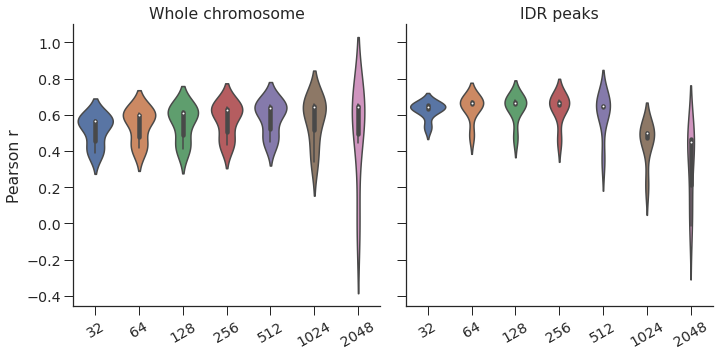

In [38]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

all_df = pd.concat([whole_df, idr_df])
g =sns.catplot(data=all_df, x='bin_size', y='pearson r', #hue='bin_size', 
               kind = "violin", col='Test set')
g.set_xticklabels(rotation=30)
# g.axes[0][0].set_xticks(g.axes[0][1].get_xticks())
g.set_xlabels('')
[t.set_visible(True) for t in [g.axes[0][0].get_xticklabels()][0]]
g.set_ylabels('Pearson r')
g.axes[0][0].set_title('Whole chromosome')
g.axes[0][1].set_title('IDR peaks')


# g.axes[0][0].legend(loc='upper center',bbox_to_anchor=(0.75,1),frameon=False)
# g._legend.remove()
# plt.xticks(g.axes[0][1].get_xticks())

In [198]:
raw_df = pd.read_csv('summary_metrics_tables/WHOLE_TRAIN_THRESHOLD.csv')

In [202]:
def filter_loss_df(filepath_path, avg_cells=True):
    # filepath_path = whole_path
    raw_df = pd.read_csv(filepath_path)
    if avg_cells:
        mean_vals = raw_df.groupby('run_path')['mse', 'scaled mse', 'JS', 'poisson NLL', 'pearson r'].mean()
        df = mean_vals.merge(raw_df.iloc[:,6:].drop_duplicates(), on='run_path')
    else:
        df = raw_df
    return df

In [219]:
df = filter_loss_df('summary_metrics_tables/IDR_TRAIN_THRESHOLD.csv')

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [220]:
df['dataset'] = [r.split('/')[-2] for r in df['data_dir'].values]

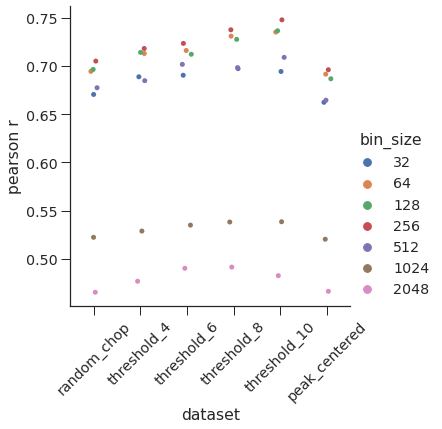

In [222]:
sns.catplot(data=df, x='dataset', y='pearson r', hue='bin_size',
            order=['random_chop', 'threshold_4', 'threshold_6', 'threshold_8',
                   'threshold_10', 'peak_centered'])
plt.xticks(rotation=45);

In [88]:
whole_df.values[0]

array(['/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_elzar_2/run-20210905_204925-27nmtpjk',
       0.6840018431345621, 0.3212969978650411, 0.8093290686607361,
       0.5723288002714955, 'basenjimod', 32,
       'datasets/complete/random_chop/i_3072_w_1', 'r_crop', True,
       'Random chop', 'shift', 'RC + Shift', 'whole chromosome'],
      dtype=object)